In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, brier_score_loss
from sklearn.model_selection import KFold

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

import warnings
warnings.filterwarnings("ignore")


In [16]:

df = pd.read_csv("Breast_cancer_data.csv")
df.head()

mean_radius  mean_texture  mean_perimeter  mean_area  mean_smoothness  \
0        17.99         10.38          122.80     1001.0          0.11840   
1        20.57         17.77          132.90     1326.0          0.08474   
2        19.69         21.25          130.00     1203.0          0.10960   
3        11.42         20.38           77.58      386.1          0.14250   
4        20.29         14.34          135.10     1297.0          0.10030   

   diagnosis  
0          0  
1          0  
2          0  
3          0  
4          0

In [17]:
df.info()
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   mean_radius      569 non-null    float64
 1   mean_texture     569 non-null    float64
 2   mean_perimeter   569 non-null    float64
 3   mean_area        569 non-null    float64
 4   mean_smoothness  569 non-null    float64
 5   diagnosis        569 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 26.8 KB


mean_radius  mean_texture  mean_perimeter    mean_area  \
count   569.000000    569.000000      569.000000   569.000000   
mean     14.127292     19.289649       91.969033   654.889104   
std       3.524049      4.301036       24.298981   351.914129   
min       6.981000      9.710000       43.790000   143.500000   
25%      11.700000     16.170000       75.170000   420.300000   
50%      13.370000     18.840000       86.240000   551.100000   
75%      15.780000     21.800000      104.100000   782.700000   
max      28.110000     39.280000      188.500000  2501.000000   

       mean_smoothness   diagnosis  
count       569.000000  569.000000  
mean          0.096360    0.627417  
std           0.014064    0.483918  
min           0.052630    0.000000  
25%           0.086370    0.000000  
50%           0.095870    1.000000  
75%           0.105300    1.000000  
max           0.163400    1.000000

In [18]:

y = df['diagnosis']


X = df.drop('diagnosis', axis=1)

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)


Shape of X: (569, 5)
Shape of y: (569,)


In [22]:



from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()


X_scaled = scaler.fit_transform(X)


X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

print("X_scaled created successfully!")
X_scaled.head()


X_scaled created successfully!


mean_radius  mean_texture  mean_perimeter  mean_area  mean_smoothness
0     1.097064     -2.073335        1.269934   0.984375         1.568466
1     1.829821     -0.353632        1.685955   1.908708        -0.826962
2     1.579888      0.456187        1.566503   1.558884         0.942210
3    -0.768909      0.253732       -0.592687  -0.764464         3.283553
4     1.750297     -1.151816        1.776573   1.826229         0.280372

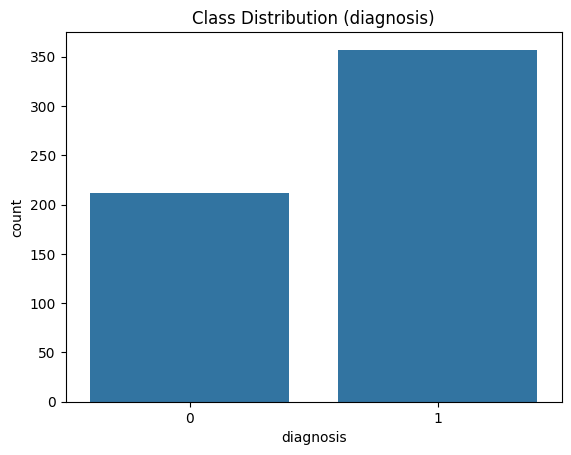

diagnosis
1    357
0    212
Name: count, dtype: int64
Percentage of class 1: 62.74 %


In [7]:

sns.countplot(x=y)
plt.title("Class Distribution (diagnosis)")
plt.show()

print(y.value_counts())
print("Percentage of class 1:", round((y.mean())*100, 2), "%")


In [27]:
features = df.drop("diagnosis", axis=1)
labels = df["diagnosis"]

print("Features and labels created.")
features.head()


Features and labels created.


mean_radius  mean_texture  mean_perimeter  mean_area  mean_smoothness
0        17.99         10.38          122.80     1001.0          0.11840
1        20.57         17.77          132.90     1326.0          0.08474
2        19.69         21.25          130.00     1203.0          0.10960
3        11.42         20.38           77.58      386.1          0.14250
4        20.29         14.34          135.10     1297.0          0.10030

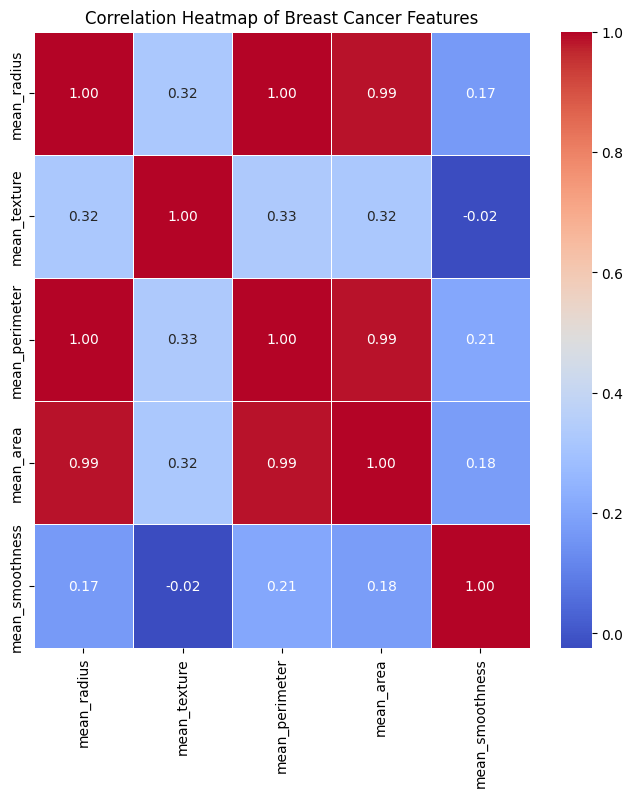

In [28]:


import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,8))
correlation_matrix = features.corr()

sns.heatmap(
    correlation_matrix,
    annot=True,
    linewidths=.5,
    fmt='.2f',
    cmap='coolwarm'
)

plt.title("Correlation Heatmap of Breast Cancer Features")
plt.show()


Upon examination, the most notable and highest correlations are observed in the following pairs:

• The correlation between ‘mean_radius’ and ‘mean_perimeter’ is 1.00.

• The correlation between ‘mean_radius’ and ‘mean_area’ is 0.99.

• The correlation between ‘mean_perimeter’ and ‘mean_area’ is 0.99.


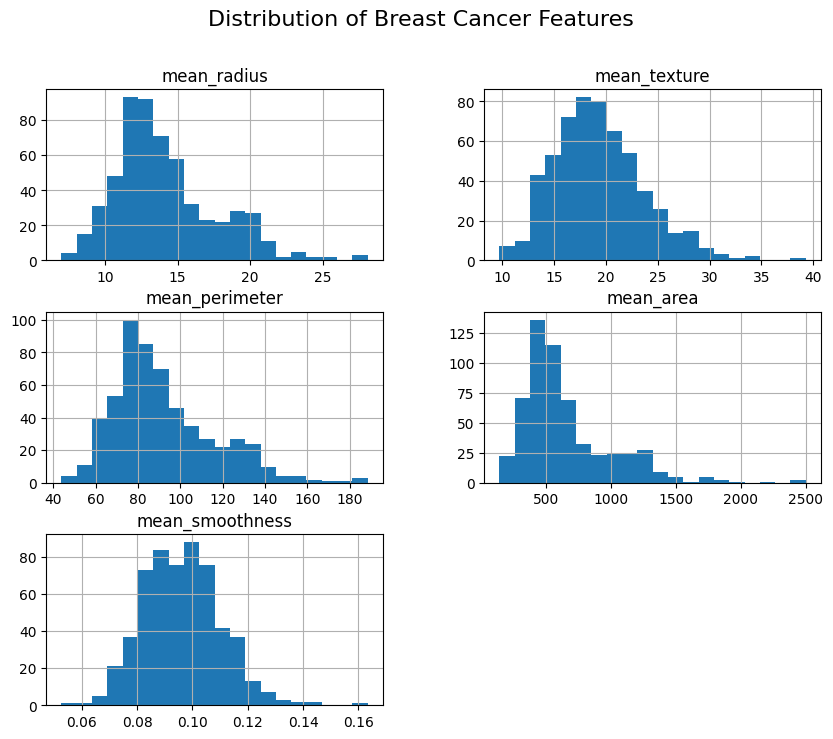

In [29]:


import matplotlib.pyplot as plt

features.hist(figsize=(10, 8), bins=20)
plt.suptitle("Distribution of Breast Cancer Features", fontsize=16)
plt.show()


Following are the observations made from the above plot:

The distributions of mean_texture and mean_smoothness exhibit a degree of symmetry.

In contrast, the distributions of the remaining attributes (mean_radius, mean_perimeter, and mean_area) are right-skewed.

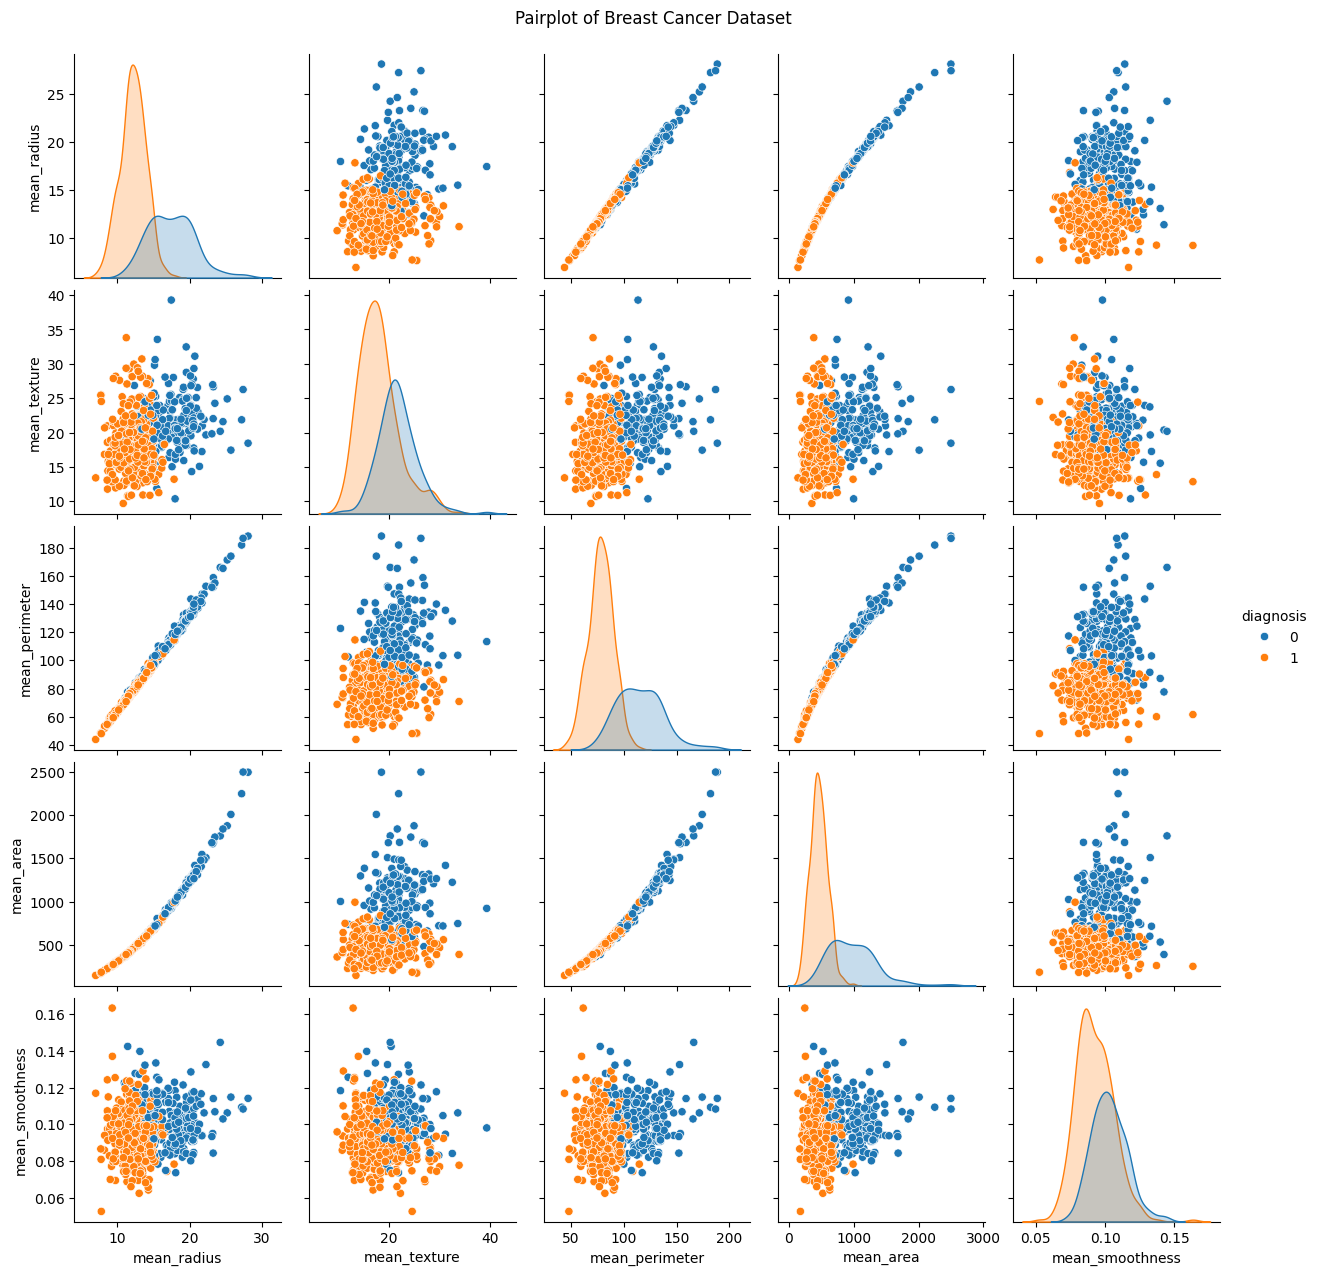

In [30]:
sns.pairplot(df, hue='diagnosis', diag_kind='kde')
plt.suptitle("Pairplot of Breast Cancer Dataset", y=1.02)
plt.show()

In [31]:
# Train Test Data Split

from sklearn.model_selection import train_test_split


features_train_all, features_test_all, labels_train_all, labels_test_all = \
train_test_split(features, labels, test_size=0.1, random_state=21,
                 stratify=labels)

for dataset in [features_train_all, features_test_all, labels_train_all, labels_test_all]:
    dataset.reset_index(drop=True, inplace=True)

print("Training set size:", features_train_all.shape)
print("Testing set size:", features_test_all.shape)


Training set size: (512, 5)
Testing set size: (57, 5)


In [33]:
features_train_all_std = (features_train_all - features_train_all.mean()) / \
                         features_train_all.std()
features_test_all_std = (features_test_all - features_test_all.mean()) / \
                        features_test_all.std()
features_train_all_std.describe()


mean_radius  mean_texture  mean_perimeter     mean_area  \
count  5.120000e+02  5.120000e+02    5.120000e+02  5.120000e+02   
mean   3.261280e-16  7.910339e-16    1.023487e-16  9.367507e-17   
std    1.000000e+00  1.000000e+00    1.000000e+00  1.000000e+00   
min   -2.090492e+00 -2.270661e+00   -2.047086e+00 -1.510420e+00   
25%   -7.035141e-01 -7.426022e-01   -7.083984e-01 -6.862631e-01   
50%   -1.907154e-01 -9.684349e-02   -2.016490e-01 -2.767540e-01   
75%    4.849465e-01  5.737521e-01    5.073312e-01  3.897502e-01   
max    3.907273e+00  3.429993e+00    4.052232e+00  5.512077e+00   

       mean_smoothness  
count     5.120000e+02  
mean     -8.812395e-16  
std       1.000000e+00  
min      -3.132638e+00  
25%      -7.076879e-01  
50%       9.480826e-05  
75%       6.343509e-01  
max       4.774683e+00

In [34]:
# metric calculation

def calc_metrics(confusion_matrix):
    TP, FN = confusion_matrix[1][1], confusion_matrix[1][0]
    FP, TN = confusion_matrix[0][1], confusion_matrix[0][0]

    TPR = TP / (TP + FN) if (TP + FN) else 0
    TNR = TN / (TN + FP) if (TN + FP) else 0
    FPR = FP / (TN + FP) if (TN + FP) else 0
    FNR = FN / (TP + FN) if (TP + FN) else 0

    Precision = TP / (TP + FP) if (TP + FP) else 0
    F1_measure = 2 * TP / (2 * TP + FP + FN) if (2 * TP + FP + FN) else 0
    Accuracy = (TP + TN) / (TP + TN + FP + FN)
    Error_rate = 1 - Accuracy
    BACC = (TPR + TNR) / 2
    TSS = TPR - FPR
    HSS = 2 * (TP * TN - FP * FN) / (
        (TP + FN) * (FN + TN) + (TP + FP) * (FP + TN)
    )

    metrics = [TP, TN, FP, FN, TPR, TNR, FPR, FNR,
               Precision, F1_measure, Accuracy, Error_rate,
               BACC, TSS, HSS]

    return metrics


In [35]:
import numpy as np
from sklearn.metrics import confusion_matrix, roc_auc_score, brier_score_loss

def get_metrics(model, X_train, X_test, y_train, y_test, LSTM_flag):

    def calc_metrics(conf_matrix):
        TP, FN = conf_matrix[0][0], conf_matrix[0][1]
        FP, TN = conf_matrix[1][0], conf_matrix[1][1]

        TPR = TP / (TP + FN) if (TP + FN) else 0
        TNR = TN / (TN + FP) if (TN + FP) else 0
        FPR = FP / (TN + FP) if (TN + FP) else 0
        FNR = FN / (TP + FN) if (TP + FN) else 0
        Precision = TP / (TP + FP) if (TP + FP) else 0
        F1_measure = 2 * TP / (2 * TP + FP + FN) if (2 * TP + FP + FN) else 0
        Accuracy = (TP + TN) / (TP + TN + FP + FN)
        Error_rate = 1 - Accuracy
        BACC = (TPR + TNR) / 2
        TSS = TPR - FPR
        HSS = 2 * (TP * TN - FP * FN) / (
            (TP + FN) * (FN + TN) + (TP + FP) * (FP + TN)
        )

        return [
            TP, TN, FP, FN, TPR, TNR, FPR, FNR,
            Precision, F1_measure, Accuracy, Error_rate,
            BACC, TSS, HSS
        ]

    metrics = []

    if LSTM_flag == 1:
        Xtrain = np.array(X_train)
        Xtest  = np.array(X_test)
        ytrain = np.array(y_train)
        ytest  = np.array(y_test)

        Xtrain_reshaped = Xtrain.reshape(len(Xtrain), Xtrain.shape[1], 1)
        Xtest_reshaped  = Xtest.reshape(len(Xtest),  Xtest.shape[1], 1)

        model.fit(Xtrain_reshaped, ytrain,
                  epochs=50,
                  validation_data=(Xtest_reshaped, ytest),
                  verbose=0)

        predict_prob = model.predict(Xtest_reshaped)
        pred_labels = (predict_prob > 0.5).astype(int)

        matrix = confusion_matrix(ytest, pred_labels, labels=[1, 0])

        lstm_brier = brier_score_loss(ytest, predict_prob)
        lstm_auc   = roc_auc_score(ytest, predict_prob)
        lstm_acc   = model.evaluate(Xtest_reshaped, ytest, verbose=0)[1]

        metrics.extend(calc_metrics(matrix))
        metrics.extend([lstm_brier, lstm_auc, lstm_acc])

        return metrics

    else:
        model.fit(X_train, y_train)

        predicted = model.predict(X_test)
        predicted_prob = model.predict_proba(X_test)[:, 1]

        matrix = confusion_matrix(y_test, predicted, labels=[1, 0])

        ml_brier = brier_score_loss(y_test, predicted_prob)
        ml_auc   = roc_auc_score(y_test, predicted_prob)
        ml_acc   = model.score(X_test, y_test)

        metrics.extend(calc_metrics(matrix))
        metrics.extend([ml_brier, ml_auc, ml_acc])

        return metrics


Selecting Classification Algorithms

I have decided to select the following classification algorithms

1.Random Forest

2.Support Vector Machine (SVM)


For Deep Learning algorithm, I have decided to use LSTM

Long Short-Term Memory (LSTM)

In [37]:
param_grid_rf = {
    "n_estimators": [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    "min_samples_split": [2, 4, 6, 8, 10]
}

rf_classifier = RandomForestClassifier()

grid_search_rf = GridSearchCV(estimator=rf_classifier,
                              param_grid=param_grid_rf,
                              cv=10,
                              n_jobs=-1)

grid_search_rf.fit(features_train_all_std, labels_train_all)

best_rf_params = grid_search_rf.best_params_
print("\nBest Parameters for Random Forest based on GridSearchCV: ",
      best_rf_params)
print('\n')

min_samples_split = best_rf_params['min_samples_split']
n_estimators = best_rf_params['n_estimators']



Best Parameters for Random Forest based on GridSearchCV:  {'min_samples_split': 4, 'n_estimators': 100}




In [38]:
param_grid_svc = {"kernel": ["linear"], "C": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}

svc_classifier = SVC(probability=True)

grid_search_svc = GridSearchCV(estimator=svc_classifier,
                               param_grid=param_grid_svc,
                               cv=10,
                               n_jobs=-1)

grid_search_svc.fit(features_train_all_std, labels_train_all)

best_svc_params = grid_search_svc.best_params_
print("\nBest Parameters for Support Vector Machine based on GridSearchCV: ",
      best_svc_params)
print('\n')

C_value = best_svc_params['C']



Best Parameters for Support Vector Machine based on GridSearchCV:  {'C': 3, 'kernel': 'linear'}




In [44]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import pandas as pd

cv_stratified = StratifiedKFold(n_splits=10, shuffle=True, random_state=21)

metric_columns = ['TP','TN','FP','FN','TPR','TNR','FPR','FNR',
                  'Precision','F1_measure','Accuracy','Error_rate',
                  'BACC','TSS','HSS','Brier_score','AUC','Acc_by_package_fn']

rf_metrics_list, svm_metrics_list, lstm_metrics_list = [], [], []

for iter_num, (train_index, test_index) in enumerate(
        cv_stratified.split(features_train_all_std, labels_train_all), start=1):

    rf_model = RandomForestClassifier(min_samples_split=min_samples_split,
                                      n_estimators=n_estimators,
                                      random_state=42)

    svm_model = SVC(C=C_value, kernel='linear', probability=True,
                    random_state=42)

    features_train = features_train_all_std.iloc[train_index, :]
    features_test  = features_train_all_std.iloc[test_index, :]
    labels_train   = labels_train_all.iloc[train_index]
    labels_test    = labels_train_all.iloc[test_index]

    n_features = features_train.shape[1]

    lstm_model = Sequential()
    lstm_model.add(LSTM(64, activation='relu',input_shape=(n_features, 1),return_sequences=False))
    lstm_model.add(Dense(1, activation='sigmoid'))
    lstm_model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])


    rf_metrics   = get_metrics(rf_model,  features_train, features_test,
                               labels_train, labels_test, 0)
    svm_metrics  = get_metrics(svm_model, features_train, features_test,
                               labels_train, labels_test, 0)
    lstm_metrics = get_metrics(lstm_model, features_train, features_test,
                               labels_train, labels_test, 1)

    rf_metrics_list.append(rf_metrics)
    svm_metrics_list.append(svm_metrics)
    lstm_metrics_list.append(lstm_metrics)

    metrics_all_df = pd.DataFrame([rf_metrics,
                                   svm_metrics,
                                   lstm_metrics],
                                  columns=metric_columns,
                                  index=['RF','SVM','LSTM'])

    print('\nIteration {}:\n'.format(iter_num))
    print(' Metrics for all Algorithms in Iteration {} \n'
          .format(iter_num))
    print(metrics_all_df.round(decimals=2).T)
    print('\n')


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 434ms/step

Iteration 1:

 Metrics for all Algorithms in Iteration 1 

                      RF    SVM   LSTM
TP                 32.00  31.00  32.00
TN                 17.00  17.00  17.00
FP                  3.00   3.00   3.00
FN                  0.00   1.00   0.00
TPR                 1.00   0.97   1.00
TNR                 0.85   0.85   0.85
FPR                 0.15   0.15   0.15
FNR                 0.00   0.03   0.00
Precision           0.91   0.91   0.91
F1_measure          0.96   0.94   0.96
Accuracy            0.94   0.92   0.94
Error_rate          0.06   0.08   0.06
BACC                0.92   0.91   0.92
TSS                 0.85   0.82   0.85
HSS                 0.87   0.83   0.87
Brier_score         0.05   0.04   0.03
AUC                 0.99   0.99   1.00
Acc_by_package_fn   0.94   0.92   0.94


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 440ms/step

Iteration 2:

 Metrics for all Algorithms in Iteration 2 

                      RF    SVM   LSTM
TP                 2

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 443ms/step

Iteration 3:

 Metrics for all Algorithms in Iteration 3 

                      RF    SVM   LSTM
TP                 30.00  30.00  32.00
TN                 16.00  16.00  16.00
FP                  3.00   3.00   3.00
FN                  2.00   2.00   0.00
TPR                 0.94   0.94   1.00
TNR                 0.84   0.84   0.84
FPR                 0.16   0.16   0.16
FNR                 0.06   0.06   0.00
Precision           0.91   0.91   0.91
F1_measure          0.92   0.92   0.96
Accuracy            0.90   0.90   0.94
Error_rate          0.10   0.10   0.06
BACC                0.89   0.89   0.92
TSS                 0.78   0.78   0.84
HSS                 0.79   0.79   0.87
Brier_score         0.06   0.05   0.04
AUC                 0.98   0.98   0.99
Acc_by_package_fn   0.90   0.90   0.94


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 446ms/step

Iteration 4:

 Metrics for all Algorithms in Iteration 4 

                      RF    SVM   LSTM
TP                 3

In [47]:
metric_index_df = ['iter1', 'iter2', 'iter3', 'iter4', 'iter5',
                   'iter6', 'iter7', 'iter8', 'iter9', 'iter10']



rf_metrics_df = pd.DataFrame(rf_metrics_list,
                             columns=metric_columns,
                             index=metric_index_df)

svm_metrics_df = pd.DataFrame(svm_metrics_list,
                              columns=metric_columns,
                              index=metric_index_df)

lstm_metrics_df = pd.DataFrame(lstm_metrics_list,
                               columns=metric_columns,
                               index=metric_index_df)

for i, metrics_df in enumerate([
                                rf_metrics_df,
                                svm_metrics_df,
                                lstm_metrics_df], start=1):

    print('\nMetrics for Algorithm {}:\n'.format(i))
    print(metrics_df.round(decimals=2).T)
    print('\n')



Metrics for Algorithm 1:

                   iter1  iter2  iter3  iter4  iter5  iter6  iter7  iter8  \
TP                 32.00  29.00  30.00  31.00  31.00  30.00  32.00  31.00   
TN                 17.00  18.00  16.00  15.00  18.00  18.00  14.00  15.00   
FP                  3.00   1.00   3.00   4.00   1.00   1.00   5.00   4.00   
FN                  0.00   4.00   2.00   1.00   1.00   2.00   0.00   1.00   
TPR                 1.00   0.88   0.94   0.97   0.97   0.94   1.00   0.97   
TNR                 0.85   0.95   0.84   0.79   0.95   0.95   0.74   0.79   
FPR                 0.15   0.05   0.16   0.21   0.05   0.05   0.26   0.21   
FNR                 0.00   0.12   0.06   0.03   0.03   0.06   0.00   0.03   
Precision           0.91   0.97   0.91   0.89   0.97   0.97   0.86   0.89   
F1_measure          0.96   0.92   0.92   0.93   0.97   0.95   0.93   0.93   
Accuracy            0.94   0.90   0.90   0.90   0.96   0.94   0.90   0.90   
Error_rate          0.06   0.10   0.10   0.10   0

In [48]:

rf_avg_df = rf_metrics_df.mean()
svm_avg_df = svm_metrics_df.mean()
lstm_avg_df = lstm_metrics_df.mean()


avg_performance_df = pd.DataFrame({
    'RF': rf_avg_df,
    'SVM': svm_avg_df,
    'LSTM': lstm_avg_df
}, index=metric_columns)


print(avg_performance_df.round(decimals=2))
print('\n')


                      RF    SVM   LSTM
TP                 30.90  30.90  30.80
TN                 16.50  16.30  16.80
FP                  2.60   2.80   2.30
FN                  1.20   1.20   1.30
TPR                 0.96   0.96   0.96
TNR                 0.86   0.85   0.88
FPR                 0.14   0.15   0.12
FNR                 0.04   0.04   0.04
Precision           0.92   0.92   0.93
F1_measure          0.94   0.94   0.94
Accuracy            0.93   0.92   0.93
Error_rate          0.07   0.08   0.07
BACC                0.91   0.91   0.92
TSS                 0.83   0.82   0.84
HSS                 0.84   0.83   0.85
Brier_score         0.05   0.05   0.05
AUC                 0.98   0.98   0.98
Acc_by_package_fn   0.93   0.92   0.93




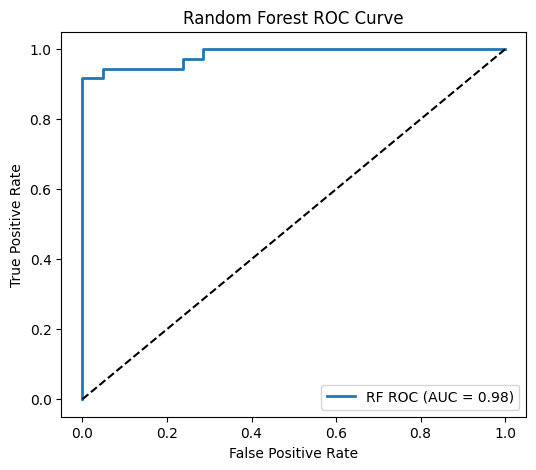

In [52]:
import sklearn.metrics

# Random Forest Model
rf_model = RandomForestClassifier(min_samples_split=min_samples_split,
                                  n_estimators=n_estimators)
rf_model.fit(features_train_all_std, labels_train_all)

y_score_rf = rf_model.predict_proba(features_test_all_std)[:, 1]

fpr_rf, tpr_rf, _ = roc_curve(labels_test_all, y_score_rf)
roc_auc_rf = sklearn.metrics.auc(fpr_rf, tpr_rf)

plt.figure(figsize=(6,5))
plt.plot(fpr_rf, tpr_rf, label="RF ROC (AUC = {:.2f})".format(roc_auc_rf), linewidth=2)
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Random Forest ROC Curve")
plt.legend()
plt.show()



SVM AUC: 0.9921


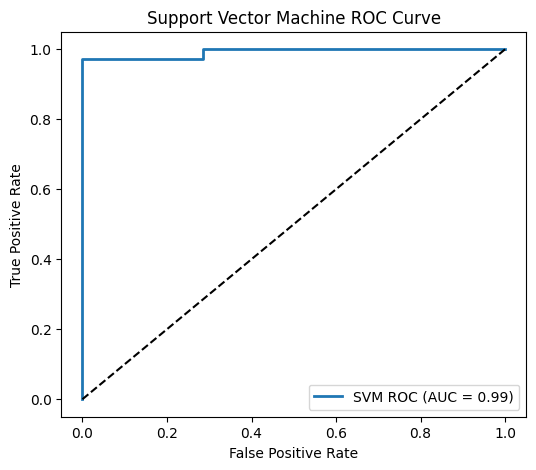

In [53]:
import sklearn.metrics


svm_model = SVC(C=C_value, kernel='linear', probability=True)


svm_model.fit(features_train_all_std, labels_train_all)


y_score_svm = svm_model.predict_proba(features_test_all_std)[:, 1]


fpr_svm, tpr_svm, _ = roc_curve(labels_test_all, y_score_svm)
roc_auc_svm = sklearn.metrics.auc(fpr_svm, tpr_svm)


print("SVM AUC:", round(roc_auc_svm, 4))


plt.figure(figsize=(6,5))
plt.plot(fpr_svm, tpr_svm,
         label="SVM ROC (AUC = {:.2f})".format(roc_auc_svm), linewidth=2)
plt.plot([0,1], [0,1], 'k--')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Support Vector Machine ROC Curve")
plt.legend(loc="lower right")
plt.show()


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 447ms/step
LSTM AUC: 0.9907


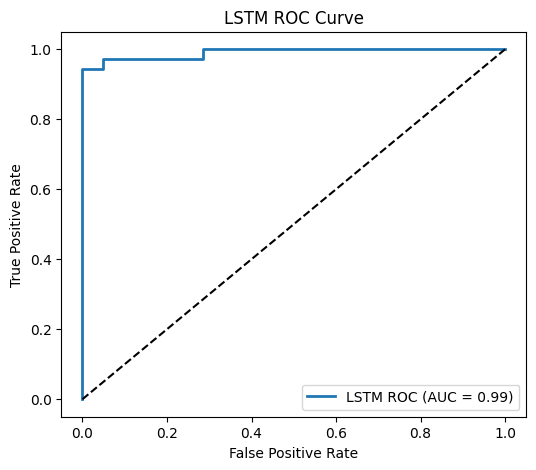

In [54]:
import sklearn.metrics


X_train_lstm = np.array(features_train_all_std).reshape(-1, n_features, 1)
X_test_lstm  = np.array(features_test_all_std).reshape(-1, n_features, 1)

y_train_lstm = np.array(labels_train_all)
y_test_lstm  = np.array(labels_test_all)


lstm_model = Sequential()
lstm_model.add(LSTM(64, activation='relu', input_shape=(n_features, 1)))
lstm_model.add(Dense(1, activation='sigmoid'))

lstm_model.compile(optimizer='adam', loss='binary_crossentropy')


lstm_model.fit(X_train_lstm, y_train_lstm, epochs=50, verbose=0)


y_score_lstm = lstm_model.predict(X_test_lstm).ravel()


fpr_lstm, tpr_lstm, _ = roc_curve(y_test_lstm, y_score_lstm)
roc_auc_lstm = sklearn.metrics.auc(fpr_lstm, tpr_lstm)


print("LSTM AUC:", round(roc_auc_lstm, 4))

plt.figure(figsize=(6,5))
plt.plot(fpr_lstm, tpr_lstm,
         label="LSTM ROC (AUC = {:.2f})".format(roc_auc_lstm), linewidth=2)

plt.plot([0,1], [0,1], 'k--')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("LSTM ROC Curve")
plt.legend(loc="lower right")
plt.show()


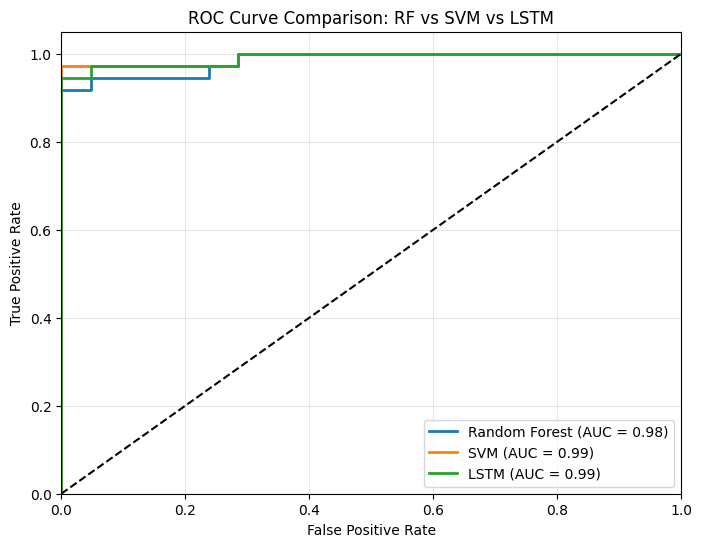

In [55]:
plt.figure(figsize=(8,6))

plt.plot(fpr_rf, tpr_rf, linewidth=2,
         label="Random Forest (AUC = {:.2f})".format(roc_auc_rf))

plt.plot(fpr_svm, tpr_svm, linewidth=2,
         label="SVM (AUC = {:.2f})".format(roc_auc_svm))

plt.plot(fpr_lstm, tpr_lstm, linewidth=2,
         label="LSTM (AUC = {:.2f})".format(roc_auc_lstm))

plt.plot([0,1], [0,1], 'k--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison: RF vs SVM vs LSTM")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()


In [56]:
print(avg_performance_df.round(decimals=2))
print('\n')


                      RF    SVM   LSTM
TP                 30.90  30.90  30.80
TN                 16.50  16.30  16.80
FP                  2.60   2.80   2.30
FN                  1.20   1.20   1.30
TPR                 0.96   0.96   0.96
TNR                 0.86   0.85   0.88
FPR                 0.14   0.15   0.12
FNR                 0.04   0.04   0.04
Precision           0.92   0.92   0.93
F1_measure          0.94   0.94   0.94
Accuracy            0.93   0.92   0.93
Error_rate          0.07   0.08   0.07
BACC                0.91   0.91   0.92
TSS                 0.83   0.82   0.84
HSS                 0.84   0.83   0.85
Brier_score         0.05   0.05   0.05
AUC                 0.98   0.98   0.98
Acc_by_package_fn   0.93   0.92   0.93




In [59]:
#extracting all the tables to a excel sheet
with pd.ExcelWriter("Model_Performance_All_Folds.xlsx") as writer:
    # Per-fold sheets
    for i in range(10):
        fold_df = pd.DataFrame({
            'RF': rf_metrics_list[i],
            'SVM': svm_metrics_list[i],
            'LSTM': lstm_metrics_list[i]
        }, index=metric_columns)

        fold_df.to_excel(writer, sheet_name=f"Fold{i+1}")


    avg_performance_df.round(2).to_excel(writer, sheet_name="Summary")
